

# <font color='LIGHBLUE' size='6'>Análise de Sentimentos do E-commerce Olist</font>

> Professora: Bárbara Silveira<br>
> Aluno: Daniel Moysés Marques Dutra de Oliveira<br>
>PUC MINAS - Ciência de Dados e inteligência Artificial

<br>
 
<font color='LIGHTGREEN' size='4'>Dados fornecidos espontaneamente pela plataforma Olist</font>

> Link: [https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

---
<br>

<font color='ORANGE' size='4'>Objetivo </font>

> O objetivo deste trabalho é analisar e criar modelos classificadores capazes de classificar os sentimentos de comentários feitos por usuários na plataforma de e-commerce olist.com

<br><br>

<font color='ORANGE' size='4'>Descrição do Dataset e abordagem do problema</font>
<br>
> O Dataset disponibilizado pela plataforma Olist é composto por várias tabelas, mas o foco desse trabalho será voltado para a tabela "olist_order_reviews". Essa tabela possui comentários e notas postadas por usuários da plataforma. Todos os comentários foram feitos entre 2016 e 2018 e a tabela usada nesse trabalho possui as seguintes colunas:

> 1. review_id_order_id	
> 2. review_score	
> 3. review_comment_title	
> 4. review_comment_message	
> 5. review_creation_date	
> 6. review_answer_timestamp

> As colunas de número 1(review_id_order_id), 3(review_comment_title), 5(review_creation_date) e 6(review_answer_timestamp) serão descartadas, e as colunas 2(review_score) e 4(review_comment_message) serão usadas na análise e criação de modelo classificador de sentimentos. 

> A coluna 2(review_score) representa a nota ou classificação que os usuários deram para suas experiências na plataforma. As notas estão no intervalo<font color='LIGHTGREEN' size='3'> de 1 a 5 estrelas. </font>
> Usaremos a coluna 2 como referência para criarmos uma nova coluna que receberá os valores 'positivo','negativo' ou 'neutro', de acordo com a regra a seguir:

> * Notas 1 e 2 = 'negativo'<br>
> * Notas 3 = 'neutro'<br>
> * Notas 4 e 5 = 'positivo'


> A coluna 4(review_comment_message) possui todos os comentários postados pelos usuários em suas avaliações na plataforma. Esses comentários serão limpos, tokenizados e vetorizados para serem usados no treinamento dos modelos.

> Os Algoritmos selecionados para treinamento foram <font color='LIGHTGREEN' size='3'>LogisticRegression do sklearn e o XGBClassifier do XGBoost</font>. Compararemos o resultado da avaliação desses algoritmos com o <font color='LIGHTGREEN' size='3'>Algoritmo LeIA, baseado no Vader(VaderSentiment).</font>

# <font color='LIGHBLUE' size='5'>Carregando Bibliotecas</font>



In [1]:
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
import string
#from unidecode import unidecode
import pandas as pd
import bz2

import warnings
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer


from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
tqdm_notebook.pandas()

import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  app.launch_new_instance()


# <font color='LIGHBLUE' size='5'>Carregando Dataset e separando colunas</font>

 > Tabela olist_order_reviews

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
avaliacoes = pd.read_csv('/content/drive/MyDrive/olist_order_reviews_dataset.csv')
avaliacoes.shape

(100000, 7)

In [4]:
avaliacoes.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [5]:
df = avaliacoes.loc[:,['review_score','review_comment_message']] 
df

,review_score,review_comment_message
0,4,NaN
1,5,NaN
2,5,NaN
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
...,...,...
99995,5,NaN
99996,5,"Excelente mochila, entrega super rápida. Super..."
99997,4,NaN
99998,1,Solicitei a compra de uma capa de retrovisor c...


# <font color='LIGHBLUE' size='5'>Criando coluna 'sentimento'</font>

> A coluna 'sentimento' sendo criada seguindo a regra:
> * Notas 1 e 2 = 'negativo'<br>
> * Notas 3 = 'neutro'<br>
> * Notas 4 e 5 = 'positivo'

In [6]:
def criasentimento(numero):
  if numero == 1 or numero == 2:
    res = 'negativo'
  elif numero == 4 or numero == 5:
    res = 'positivo'
  else:
    res = 'neutro'

  return res


df['sentimento'] = df['review_score'].apply(criasentimento)
df


,review_score,review_comment_message,sentimento
0,4,NaN,positivo
1,5,NaN,positivo
2,5,NaN,positivo
3,5,Recebi bem antes do prazo estipulado.,positivo
4,5,Parabéns lojas lannister adorei comprar pela I...,positivo
...,...,...,...
99995,5,NaN,positivo
99996,5,"Excelente mochila, entrega super rápida. Super...",positivo
99997,4,NaN,positivo
99998,1,Solicitei a compra de uma capa de retrovisor c...,negativo


# <font color='LIGHBLUE' size='5'>Limpando NaNs</font>

In [7]:
df.isnull().sum()

review_score                  0
review_comment_message    58247
sentimento                    0
dtype: int64

In [8]:
novodf = df.loc[:,['review_comment_message','sentimento']]
novodf.dropna(inplace = True  )
novodf.shape

(41753, 2)

In [9]:
novodf.isnull().sum()

review_comment_message    0
sentimento                0
dtype: int64

# <font color='LIGHBLUE' size='4'>Visualização Frequência Sentimentos</font>

In [10]:
novodf.sentimento.value_counts(normalize = True) * 100

positivo    63.899600
negativo    27.322588
neutro       8.777812
Name: sentimento, dtype: float64

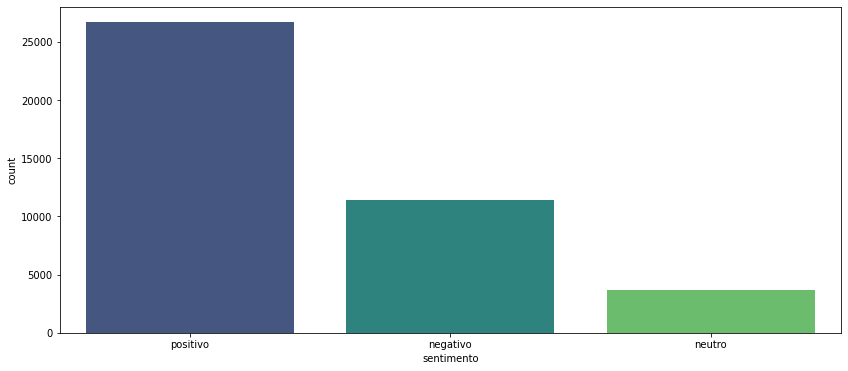

In [11]:
plt.figure(figsize = (14,6))
sns.countplot(novodf['sentimento'], palette='viridis')

# <font color='LIGHBLUE' size='4'>Visualização Frequência X Cumprimento comentário (palavras) pré Tokenização e remoção de stopwords</font>

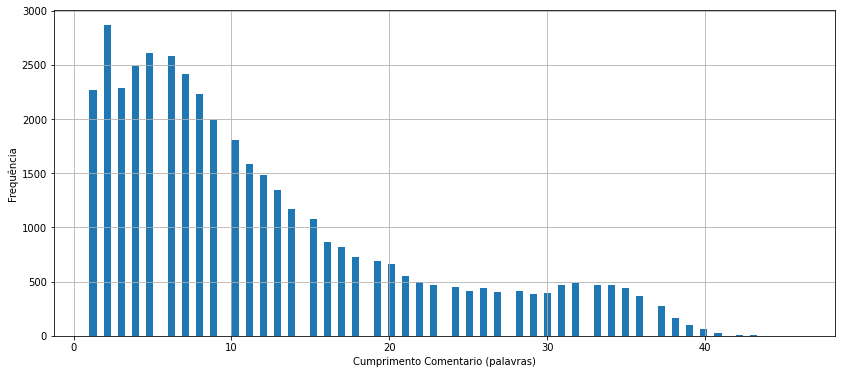

Média de Palavras por comentário: 12.047804948147439


In [12]:
words_per_review = novodf['review_comment_message'].apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100, figsize=[14,6])
plt.xlabel('Cumprimento Comentario (palavras)')
plt.ylabel('Frequência')

plt.show()
print('Média de Palavras por comentário:', words_per_review.mean())

# <font color='LIGHBLUE' size='4'>Tokenização, Remoção de Stopwords e remoção de pontuação</font>

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
comentarios = []
stop_words = set(stopwords.words('portuguese'))


for words in novodf['review_comment_message']:
  corpus_alt = re.findall(r"\w+(?:'\w+)?|[^\w\s]", words)
  corpus_alt = [t.lower() for t in corpus_alt] #para lowercase
  #print('2. Remove stopwords')
  pt_stops = stopwords.words('portuguese')
  corpus_alt = [t for t in corpus_alt if t not in pt_stops]
  #print('3. Remove números')
  corpus_alt = [re.sub(r'\d', '', t) for t in corpus_alt]
  #print('4. Remove pontuação')
  palavras = [t for t in corpus_alt if t not in string.punctuation]
      
  comentarios.append(' '.join(palavras))

comentarios

['recebi bem antes prazo estipulado',
 'parabéns lojas lannister adorei comprar internet seguro prático parabéns todos feliz páscoa',
 'aparelho eficiente site marca aparelho impresso desinfector chegar outro nome atualizar marca correta vez aparelho',
 'pouco travando valor ta boa',
 'vendedor confiável produto ok entrega antes prazo',
 'gostaria saber sempre recebi compra agora decpcionou',
 'péssimo',
 'loja nota',
 'obrigado atençao amim dispensada',
 'compra realizada facilmente entrega efetuada antes prazo dado produto começou ser usado presente problemas',
 'relógio bonito barato',
 'gostei comprei gato lebre',
 'sempre compro internet entrega ocorre antes prazo combinado acredito ser prazo máximo stark prazo máximo esgotou ainda recebi produto',
 'recebi exatamente esperava demais encomendas outros vendedores atrasaram chegou prazo',
 'recomendo',
 'boa',
 'tô completamente apaixonada loja super responsável confiável',
 'nada chegar pedido',
 'bom cheiroso',
 'otimo vendedor ch

# <font color='LIGHBLUE' size='4'>Visualização Frequência X Cumprimento comentário (palavras) pós Tokenização e remoção de stopwords</font>

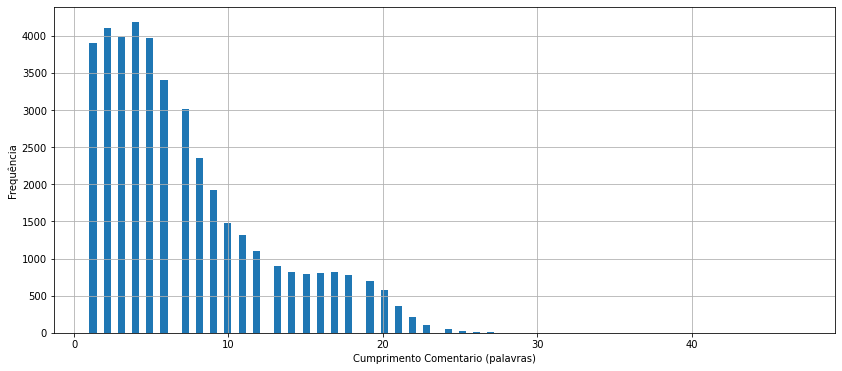

Média de Palavras por comentário: 7.172298996479295


In [15]:
dfplot = pd.DataFrame(comentarios, columns=['comentarios'])
words_per_review = dfplot['comentarios'].apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100, figsize=[14,6])
plt.xlabel('Cumprimento Comentario (palavras)')
plt.ylabel('Frequência')

plt.show()
print('Média de Palavras por comentário:', words_per_review.mean())

## <font color='LIGHBLUE' size='4'>WordCloud Comentários</font>

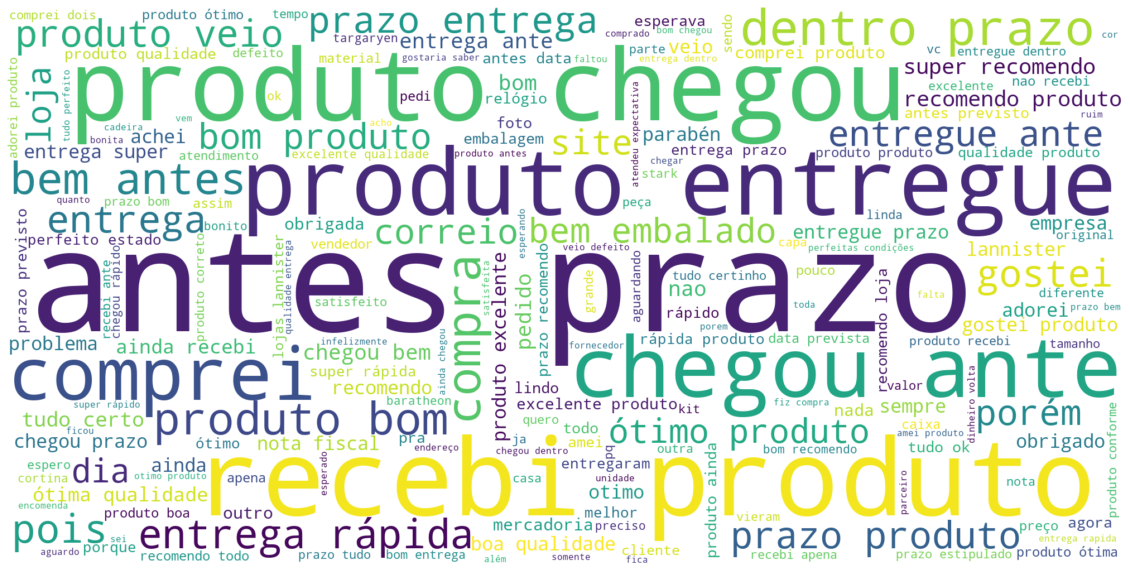

In [16]:
from wordcloud import WordCloud

#Usando wordcloud para visualizar as palavras mais frequentes
unique_string=(" ").join(comentarios)
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# <font color='LIGHBLUE' size='4'>Vetorização dos Comentários</font>

Comentários sendo vetorizados usando CountVectorizer()

In [17]:
vetorizer = CountVectorizer()
vetor = vetorizer.fit_transform(comentarios)
count_array = vetor.toarray()
df1 = pd.DataFrame(data=count_array,columns = vetorizer.get_feature_names())
df1

,__,aa,aaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaguardando,aainda,aancheira,aaprelho,ab,aba,...,últimos,úmida,única,únicar,único,únicos,útei,úteis,útil,ünica
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41749,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# <font color='LIGHBLUE' size='4'>Separando Dataset em treino e teste</font>

In [18]:
x_train, x_test, y_train, y_test = train_test_split(vetor, novodf['sentimento'], test_size = 0.2, random_state = 7)
y_test.value_counts()/y_test.shape[0]

positivo    0.635732
negativo    0.273740
neutro      0.090528
Name: sentimento, dtype: float64

In [19]:
x_train.shape

(33402, 15374)

In [20]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)
x_train.shape

(64113, 15374)

In [21]:
y_train.value_counts()

positivo    21371
negativo    21371
neutro      21371
Name: sentimento, dtype: int64

# <font color='LIGHBLUE' size='6'>Modelo Regressão Logísitica</font>

In [22]:
# Definindo e treinando modelo
lr_model = LogisticRegression(max_iter=500, solver='sag', warm_start=True)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=500, solver='sag', warm_start=True)

### <font color='LIGHBLUE' size='4'>Avaliação do Modelo de Regressão Logística</font>

Acurácia:  0.7375164650940007
CM [[1833  265  188]
 [ 304  235  217]
 [ 321  897 4091]]


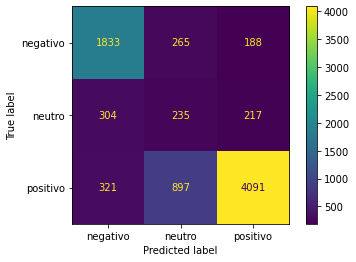

In [23]:
test_pred = lr_model.predict(x_test)

print("Acurácia: ", accuracy_score(y_test,test_pred))
#print("F1 score: ", f1_score(y_test,test_pred))
print("CM", confusion_matrix(y_test,test_pred))

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(lr_model,x_test, y_test) 
plt.show()

# <font color='LIGHBLUE' size='6'>Modelo XGBClassifier</font>

In [24]:
xgb_model = XGBClassifier(n_estimators = 500, max_depth = 10, learning_rate = 0.01, subsample = 1, random_state=123)

xgb_model.fit(x_train, y_train)

XGBClassifier(learning_rate=0.01, max_depth=10, n_estimators=500,
              objective='multi:softprob', random_state=123)

### <font color='LIGHBLUE' size='4'>Avaliação do Modelo XGBClassifier</font>

Acurácia:  0.7468566638725901
CM [[1811  202  273]
 [ 359  137  260]
 [ 459  561 4289]]


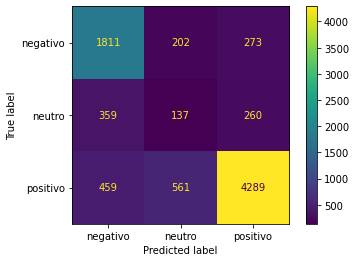

In [25]:
test_pred = xgb_model.predict(x_test)

print("Acurácia: ", accuracy_score(y_test,test_pred))
#print("F1 score: ", f1_score(y_test,test_pred))
print("CM", confusion_matrix(y_test,test_pred))

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb_model,x_test, y_test) 
plt.show()

# <font color='LIGHBLUE' size='6'>LeIA</font>

In [26]:
!pip install leia

In [27]:
from leia.leia import SentimentIntensityAnalyzer

s = SentimentIntensityAnalyzer()

# Análise de texto simples
s.polarity_scores('satisfeito produto empresa')

{'compound': 0.4215, 'neg': 0.0, 'neu': 0.417, 'pos': 0.583}

In [28]:
x_train_leia, x_test_leia, y_train_leia, y_test_leia = train_test_split(comentarios, novodf['sentimento'], test_size = 0.2, random_state = 7)
x_test_leia

['produto chegou antes prazo exatamente esperava recomendo',
 'adorei produto otima qualidade',
 'parabéns produto bom 👍',
 'maioridade cameras espiã baixo r lixo raramente funcionam qualidade péssima video som investi pouco aqui fiquei impressionado imagem som recomendo',
 'problema desde compra entrega',
 'produto chegou antes prazo',
 'produto bonito frági l chegou bem amassado',
 'instalei cartucho tinta impressora indicou vazio apresentou mensagem erro cima marcador nível tinta solicitei troca',
 'solda hastes metálicas desfez enquanto desembalava produto aguardando orientação devolução',
 'superou espectativas abajur ótimo tamanho lindo entrega feita antes prazo satisfeita',
 'ja passou prazo entrega produto ainda nao chegou aconteceu',
 'loja excelente',
 'achei lindo recomendo',
 'compro lojas americanos confiança estabelecimento',
 'chegou prazo excelente super recomendo alem ser mt bonito',
 'senti decepcionada pois recebi produto pés cor diferente combina nada ambiente vendi

### <font color='LIGHBLUE' size='4'>Avaliação do LeIA</font>

Acurácia:  0.35995689139025266
CM [[ 109 2123   54]
 [  22  624  110]
 [  46 2990 2273]]


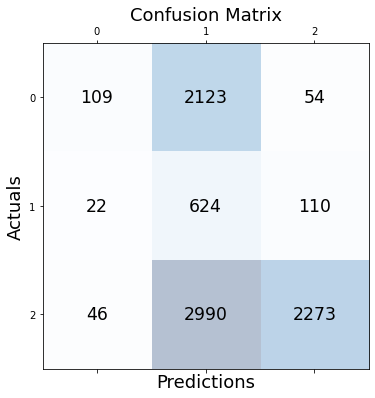

In [29]:
preds_leia = []

for frase in x_test_leia:
  res = s.polarity_scores(frase)
  if res['neg'] > res['pos'] and res['neg'] > res['neu']:
    sentimento = 'negativo'
    #print(frase,res['neg'], sentimento)
  elif res['pos'] > res['neg'] and res['pos'] > res['neu']:
    sentimento = 'positivo'
    #print(frase,res['pos'],sentimento)
  elif res['neu'] > res['neg'] and res['neu'] > res['pos']:
    sentimento = 'neutro'
    #print(frase, res['neu'],sentimento)
   
  preds_leia.append(sentimento)



print("Acurácia: ", accuracy_score(y_test_leia,preds_leia))
#print("F1 score: ", f1_score(y_test,test_pred))
print("CM", confusion_matrix(y_test_leia,preds_leia))

from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confusion_matrix(y_test_leia,preds_leia), cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix(y_test_leia,preds_leia).shape[0]):
    for j in range(confusion_matrix(y_test_leia,preds_leia).shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix(y_test_leia,preds_leia)[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# <font color='LIGHBLUE' size='6'>RandomSearch</font>

> Obs.: Esse RandomSearchCV() roda por 43 minutos

In [30]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [31]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [7,8,9,10,11,12,13],
        'n_estimators': [500,550,600,650]
        }

In [32]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(vetor,novodf['sentimento']), verbose=3, random_state=1001 )


random_search.fit(vetor,novodf['sentimento'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fa544c75650>,
                   estimator=XGBClassifier(learning_rate=0.01, max_depth=10,
                                           n_estimators=500,
                                           objective='multi:softprob',
                                           random_state=123),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [7, 8, 9, 10, 11, 12, 13],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [500, 550, 600, 650],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [33]:
print('\n Todos resultados:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 Todos resultados:
{'mean_fit_time': array([779.2663041 , 648.57392796, 377.65010118, 290.9352924 ,
       398.31038078]), 'std_fit_time': array([ 0.68186294, 10.45631467,  0.67389916,  1.21058861, 36.82300549]), 'mean_score_time': array([0.02567188, 0.03212929, 0.03144471, 0.03089142, 0.01164428]), 'std_score_time': array([0.00491621, 0.00293465, 0.00417494, 0.00437016, 0.00313401]), 'param_subsample': masked_array(data=[0.6, 0.8, 0.8, 0.8, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[650, 500, 500, 650, 650],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 1, 10, 10, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[11, 12, 12, 7, 8],
             mask=[False, False, False, Fals

In [34]:
xgb_model = XGBClassifier(colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=11,
              n_estimators=650, objective='multi:softprob', random_state=123,
              subsample=0.6)

xgb_model.fit(x_train, y_train)

XGBClassifier(colsample_bytree=1.0, gamma=1, learning_rate=0.01, max_depth=11,
              n_estimators=650, objective='multi:softprob', random_state=123,
              subsample=0.6)

Acurácia:  0.773919291102862
CM [[1843  164  279]
 [ 360  120  276]
 [ 433  376 4500]]


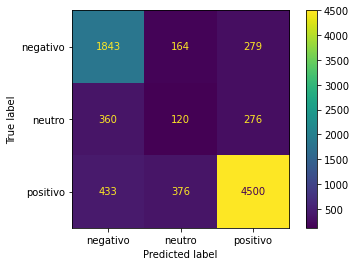

In [35]:
test_pred = xgb_model.predict(x_test)

print("Acurácia: ", accuracy_score(y_test,test_pred))
#print("F1 score: ", f1_score(y_test,test_pred))
print("CM", confusion_matrix(y_test,test_pred))

plot_confusion_matrix(xgb_model,x_test, y_test) 
plt.show()

# <font color='LIGHBLUE' size='6'>LeIA vs Usuários</font>

> Criação de nova coluna com a classificação do LeIA para comparação com as classificações dos usuários sobre a regra:

> Notas 1 e 2 - Negativo<br>
> Notas 3 - Neutro<br>
> Notas 4 e 5 - Positivo

In [36]:
novodf['sentimento_leia'] = ''
for i , row in novodf.iterrows():
  sentimento_leia = s.polarity_scores(row.review_comment_message)
  if sentimento_leia['neg'] > sentimento_leia['pos'] and sentimento_leia['neg'] > sentimento_leia['neu']:
    sentimentoLeia = 'negativo'
    #print(frase,res['neg'], sentimento)
  elif sentimento_leia['pos'] > sentimento_leia['neg'] and sentimento_leia['pos'] > sentimento_leia['neu']:
    sentimentoLeia = 'positivo'
    #print(frase,res['pos'],sentimento)
  elif sentimento_leia['neu'] > sentimento_leia['neg'] and sentimento_leia['neu'] > sentimento_leia['pos']:
    sentimentoLeia = 'neutro'
    #print(frase, res['neu'],sentimento)


  novodf['sentimento_leia'][i] = sentimentoLeia

novodf

,review_comment_message,sentimento,sentimento_leia
3,Recebi bem antes do prazo estipulado.,positivo,neutro
4,Parabéns lojas lannister adorei comprar pela I...,positivo,positivo
9,aparelho eficiente. no site a marca do aparelh...,positivo,neutro
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",positivo,positivo
15,"Vendedor confiável, produto ok e entrega antes...",positivo,neutro
...,...,...,...
99983,Entregou dentro do prazo. O produto chegou em ...,positivo,neutro
99990,"O produto não foi enviado com NF, não existe v...",neutro,neutro
99996,"Excelente mochila, entrega super rápida. Super...",positivo,positivo
99998,Solicitei a compra de uma capa de retrovisor c...,negativo,neutro


Acurácia:  0.29446985845328477
CM [[  650    92   159]
 [10597  3168 18044]
 [  161   405  8477]]


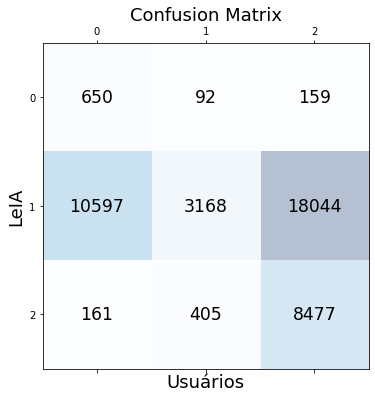

In [37]:
print("Acurácia: ", accuracy_score(novodf['sentimento_leia'],novodf['sentimento']))
#print("F1 score: ", f1_score(y_test,test_pred))
print("CM", confusion_matrix(novodf['sentimento_leia'],novodf['sentimento']))


fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confusion_matrix(novodf['sentimento_leia'],novodf['sentimento']), cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix(novodf['sentimento_leia'],novodf['sentimento']).shape[0]):
    for j in range(confusion_matrix(novodf['sentimento_leia'],novodf['sentimento']).shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix(novodf['sentimento_leia'],novodf['sentimento'])[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Usuários', fontsize=18)
plt.ylabel('LeIA', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# <font color='LIGHBLUE' size='6'>GridSearch</font>

> Obs.: Esse GridSearchCV() roda por quase 9 horas no Colab

In [38]:
'''
params2 = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6,7,8,9,10,11,12,13],
        'n_estimators': [400,450,500,550,600,650]
        }
 
 
 
grid = GridSearchCV(estimator=xgb_model, param_grid=params2, scoring='roc_auc', n_jobs=4, cv=skf.split(vetor,novodf['sentimento']), verbose=3 )
grid.fit(vetor,novodf['sentimento'])
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)
results = pd.DataFrame(grid.cv_results_)
#results.to_csv('xgb-grid-search-results-01.csv', index=False)

y_test_grid = grid.best_estimator_.predict_proba(y_test)
results_df = pd.DataFrame(data={'Coment':novodf['comentario'], 'target':y_test_grid[:,1]})
# results_df.to_csv('submission-grid-search-xgb-porto-01.csv', index=False)

'''


"\nparams2 = {\n        'min_child_weight': [1, 5, 10],\n        'gamma': [0.5, 1, 1.5, 2, 5],\n        'subsample': [0.6, 0.8, 1.0],\n        'colsample_bytree': [0.6, 0.8, 1.0],\n        'max_depth': [6,7,8,9,10,11,12,13],\n        'n_estimators': [400,450,500,550,600,650]\n        }\n \n \n \ngrid = GridSearchCV(estimator=xgb_model, param_grid=params2, scoring='roc_auc', n_jobs=4, cv=skf.split(vetor,novodf['sentimento']), verbose=3 )\ngrid.fit(vetor,novodf['sentimento'])\nprint('\n All results:')\nprint(grid.cv_results_)\nprint('\n Best estimator:')\nprint(grid.best_estimator_)\nprint('\n Best score:')\nprint(grid.best_score_ * 2 - 1)\nprint('\n Best parameters:')\nprint(grid.best_params_)\nresults = pd.DataFrame(grid.cv_results_)\n#results.to_csv('xgb-grid-search-results-01.csv', index=False)\n\ny_test_grid = grid.best_estimator_.predict_proba(y_test)\nresults_df = pd.DataFrame(data={'Coment':novodf['comentario'], 'target':y_test_grid[:,1]})\n# results_df.to_csv('submission-grid-se